borrow code from https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e

### 1、伪造数据

In [ ]:
sent_1_x = ['is', 'it', 'too', 'late', 'now', 'say', 'sorry']
sent_1_y = ['VB', 'PRP', 'RB', 'RB', 'RB', 'VB', 'JJ']
sent_2_x = ['ooh', 'ooh']
sent_2_y = ['NNP', 'NNP']
sent_3_x = ['sorry', 'yeah']
sent_3_y = ['JJ', 'NNP']
X = [sent_1_x, sent_2_x, sent_3_x]
Y = [sent_1_y, sent_2_y, sent_3_y]
print(X)
print(Y)

# map sentences to vocab
vocab = {'<PAD>': 0, 'is': 1, 'it': 2, 'too': 3, 'late': 4, 'now': 5, 'say': 6, 'sorry': 7, 'ooh': 8, 'yeah': 9} 
# fancy nested list comprehension
X =  [[vocab[word] for word in sentence] for sentence in X]
# X now looks like:  
# [[1, 2, 3, 4, 5, 6, 7], [8, 8], [7, 9]]

tags = {'<PAD>': 0, 'VB': 1, 'PRP': 2, 'RB': 3, 'JJ': 4, 'NNP': 5}
# fancy nested list comprehension
Y =  [[tags[tag] for tag in sentence] for sentence in Y]
# Y now looks like:
# [[1, 2, 3, 3, 3, 1, 4], [5, 5], [4, 5]]

print(X)
print(Y)

[['is', 'it', 'too', 'late', 'now', 'say', 'sorry'], ['ooh', 'ooh'], ['sorry', 'yeah']]
[['VB', 'PRP', 'RB', 'RB', 'RB', 'VB', 'JJ'], ['NNP', 'NNP'], ['JJ', 'NNP']]
[[1, 2, 3, 4, 5, 6, 7], [8, 8], [7, 9]]
[[1, 2, 3, 3, 3, 1, 4], [5, 5], [4, 5]]


### 2、数据预处理
对输入数据X进行pad补齐

对输入标签Y进行pad补齐

对每一个batch中的数据做自动补齐，使用pack-pad来加速一个batch的运行速度

In [4]:
import numpy as np
def pad(X):
    # pad a batch
    # get the length of each sentence
    X_lengths = [len(sentence) for sentence in X]
    # create an empty matrix with padding tokens
    pad_token = tags['<PAD>']
    longest_sent = max(X_lengths)
    batch_size = len(X)
    padded_X = np.ones((batch_size, longest_sent)) * pad_token
    # copy over the actual sequences
    for i, x_len in enumerate(X_lengths):
      sequence = X[i]
      padded_X[i, 0:x_len] = sequence[:x_len]
    return padded_X

print(pad(X))
print(pad(Y))
        
def getBatch(x, y, bs):
    x_1 = list([])
    y_1 = list([])
    for i in range(0, bs, 1):
        x_1.append(x[i])
        y_1.append(y[i])
    
    # 得到一个batch的数据
    x_var_len = list([])
    for sentence in x_1:
        x_var_len.append(len(sentence))
    inputs_len = Variable(torch.LongTensor(x_var_len))
    
    pad_x = pad(x_1)
    pad_y = pad(y_1)
    
    i = range(0, bs, 1)
    inputs = Variable(torch.LongTensor(pad_x[i, :]))
    targets = Variable(torch.LongTensor(pad_y[i, :]))
    yield (inputs, targets, inputs_len)
    
for inputs, target, inputs_len in getBatch(X, Y, 2):
    print inputs, target, inputs_len

[[1. 2. 3. 4. 5. 6. 7.]
 [8. 8. 0. 0. 0. 0. 0.]
 [7. 9. 0. 0. 0. 0. 0.]]
[[1. 2. 3. 3. 3. 1. 4.]
 [5. 5. 0. 0. 0. 0. 0.]
 [4. 5. 0. 0. 0. 0. 0.]]
tensor([[1, 2, 3, 4, 5, 6, 7],
        [8, 8, 0, 0, 0, 0, 0]]) tensor([[1, 2, 3, 3, 3, 1, 4],
        [5, 5, 0, 0, 0, 0, 0]]) tensor([7, 2])


### 3、创建模型

In [5]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F
        
class BieberLSTM(nn.Module):
    def __init__(self, nb_layers, nb_lstm_units=100, embedding_dim=3, batch_size=3, on_gpu=False):
        super(BieberLSTM, self).__init__()
        self.vocab = {'<PAD>': 0, 'is': 1, 'it': 2, 'too': 3, 'late': 4, 
                      'now': 5, 'say': 6, 'sorry': 7, 'ooh': 8,
                      'yeah': 9}
        self.tags = {'<PAD>': 0, 'VB': 1, 'PRP': 2, 'RB': 3, 'JJ': 4, 'NNP': 5}

        self.nb_layers = nb_layers
        self.nb_lstm_units = nb_lstm_units
        self.embedding_dim = embedding_dim
        self.batch_size = batch_size
        self.on_gpu = on_gpu

        # don't count the padding tag for the classifier output
        self.nb_tags = len(self.tags) - 1

        # when the model is bidirectional we double the output dimension
        self.lstm = None

        # build actual NN
        self.__build_model()

    def __build_model(self):
        # build embedding layer first
        nb_vocab_words = len(self.vocab)

        # whenever the embedding sees the padding index it'll make the whole vector zeros
        padding_idx = self.vocab['<PAD>']
        self.word_embedding = nn.Embedding(
            num_embeddings=nb_vocab_words,
            embedding_dim=self.embedding_dim,
            padding_idx=padding_idx
        )

        # design LSTM
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.nb_lstm_units,
            num_layers=self.nb_layers,
            batch_first=True,
        )

        # output layer which projects back to tag space
        self.hidden_to_tag = nn.Linear(self.nb_lstm_units, self.nb_tags)

    def init_hidden(self):
        # the weights are of the form (nb_layers, batch_size, nb_lstm_units)
        hidden_a = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        hidden_b = torch.randn(self.nb_layers, self.batch_size, self.nb_lstm_units)
        if self.on_gpu:
            hidden_a = hidden_a.cuda()
            hidden_b = hidden_b.cuda()

        hidden_a = Variable(hidden_a)
        hidden_b = Variable(hidden_b)

        return (hidden_a, hidden_b)
    
    def forward(self, X, X_lengths):
        # reset the LSTM hidden state. Must be done before you run a new batch. 
        # Otherwise the LSTM will treat a new batch as a continuation of a sequence
        self.hidden = self.init_hidden()
        batch_size, seq_len = X.size()

        # ---------------------
        # 1. embed the input
        # Dim transformation: (batch_size, seq_len, 1) -> (batch_size, seq_len, embedding_dim)
        X = self.word_embedding(X)

        # ---------------------
        # 2. Run through RNN
        # TRICK 2 ********************************
        # Dim transformation: (batch_size, seq_len, embedding_dim) -> (batch_size, seq_len, nb_lstm_units)
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(X, X_lengths, batch_first=True)
        # now run through LSTM
        X, self.hidden = self.lstm(X, self.hidden)
        # undo the packing operation
        X, _ = torch.nn.utils.rnn.pad_packed_sequence(X, batch_first=True)

        # ---------------------
        # 3. Project to tag space
        # Dim transformation: (batch_size, seq_len, nb_lstm_units) -> (batch_size * seq_len, nb_lstm_units)
        # this one is a bit tricky as well. First we need to reshape the data so it goes into the linear layer
        X = X.contiguous().view(-1, X.shape[2])

        # run through actual linear layer
        X = self.hidden_to_tag(X)

        # ---------------------
        # 4. Create softmax activations bc we're doing classification
        # Dim transformation: (batch_size * seq_len, nb_lstm_units) -> (batch_size, seq_len, nb_tags)
        X = F.log_softmax(X, dim=1)

        # I like to reshape for mental sanity so we're back to (batch_size, seq_len, nb_tags)
        X = X.view(batch_size, seq_len, self.nb_tags)

        Y_hat = X
        return Y_hat
    
    def loss(self, Y_hat, Y, X_lengths):
        # TRICK 3 ********************************
        # before we calculate the negative log likelihood, we need to mask out the activations
        # this means we don't want to take into account padded items in the output vector
        # simplest way to think about this is to flatten ALL sequences into a REALLY long sequence
        # and calculate the loss on that.

        # flatten all the labels
        Y = Y.view(-1)

        # flatten all predictions
        Y_hat = Y_hat.view(-1, self.nb_tags)

        # create a mask by filtering out all tokens that ARE NOT the padding token
        tag_pad_token = self.tags['<PAD>']
        mask = (Y > tag_pad_token).float()

        # count how many tokens we have
        nb_tokens = int(torch.sum(mask).item())

        # pick the values for the label and zero out the rest with the mask
        # 这里使用mask，把padding出来的那些元素去掉
        Y = Y - 1
        Y_hat = Y_hat[range(Y_hat.shape[0]), Y-1] * mask

        # compute cross entropy loss which ignores all <PAD> tokens
        ce_loss = -torch.sum(Y_hat) / nb_tokens

        return ce_loss

### 4、优化模型，并作图

tensor(1.6167, grad_fn=<DivBackward0>)
tensor(1.5790, grad_fn=<DivBackward0>)
tensor(1.5661, grad_fn=<DivBackward0>)
tensor(1.4855, grad_fn=<DivBackward0>)
tensor(1.4901, grad_fn=<DivBackward0>)
tensor(1.3935, grad_fn=<DivBackward0>)
tensor(1.4164, grad_fn=<DivBackward0>)
tensor(1.5185, grad_fn=<DivBackward0>)
tensor(1.4163, grad_fn=<DivBackward0>)
tensor(1.3570, grad_fn=<DivBackward0>)
tensor(1.3892, grad_fn=<DivBackward0>)
tensor(1.3505, grad_fn=<DivBackward0>)
tensor(1.2890, grad_fn=<DivBackward0>)
tensor(1.2752, grad_fn=<DivBackward0>)
tensor(1.2519, grad_fn=<DivBackward0>)
tensor(1.2251, grad_fn=<DivBackward0>)
tensor(1.3350, grad_fn=<DivBackward0>)
tensor(0.8392, grad_fn=<DivBackward0>)
tensor(1.0332, grad_fn=<DivBackward0>)
tensor(1.0907, grad_fn=<DivBackward0>)
tensor(0.9926, grad_fn=<DivBackward0>)
tensor(1.9932, grad_fn=<DivBackward0>)
tensor(2.2398, grad_fn=<DivBackward0>)
tensor(2.0640, grad_fn=<DivBackward0>)
tensor(0.9579, grad_fn=<DivBackward0>)
tensor(0.8594, grad_fn=<D

<Figure size 432x288 with 0 Axes>

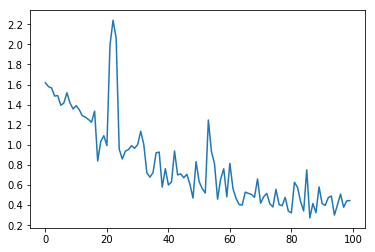

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    
    

import torch.optim as optim
batch_size = 2
model = BieberLSTM(3, batch_size=batch_size)
optimizer = optim.Adam(model.parameters(), lr=0.01)

plot_losses = []
for epoch in xrange(100):
    model.init_hidden()
    for x, y, x_len in getBatch(X, Y, batch_size):
        model.zero_grad()
        tag_scores = model(x, x_len)
        loss = model.loss(tag_scores, y, x_len)
        print(loss.item())
        plot_losses.append(loss.item())
        loss.backward()
        optimizer.step()
        
show_plot(plot_losses)